# Exploring with Spark and Pandas

### Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [96]:
from pyspark.sql import SparkSession
import pyspark.sql.functions
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
spark = SparkSession.builder.getOrCreate()

In [2]:
case = spark.read.csv("case.csv", sep=",", header=True, inferSchema=True)
dept = spark.read.csv("dept.csv", sep=",", header=True, inferSchema=True)
source = spark.read.csv("source.csv", sep=",", header=True, inferSchema=True)

In [3]:
# Joining the data frames:
df = case.join(dept, 'dept_division', 'left').join(source, 'source_id', 'left')

In [85]:
df.show(2, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------
 source_id              | svcCRMLS                             
 dept_division          | Field Operations                     
 case_id                | 1014127332                           
 case_opened_date       | 1/1/18 0:42                          
 case_closed_date       | 1/1/18 12:29                         
 SLA_due_date           | 9/26/20 0:42                         
 case_late              | NO                                   
 num_days_late          | -998.5087616000001                   
 case_closed            | YES                                  
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 5                                    
 dept_name              | Animal Care Se

#### 1. How many different cases are there, by department?

In [143]:
case_dept = df.groupby(df.dept_name).count().toPandas()
case_dept.head()

,dept_name,count
0,Animal Care Services,119362
1,Solid Waste Management,286287
2,Development Services,1397
3,Trans & Cap Improvements,97841
4,Customer Service,2889


In [144]:
case_dept = case_dept.sort_values(by='count', ascending=False).reset_index(drop=True)

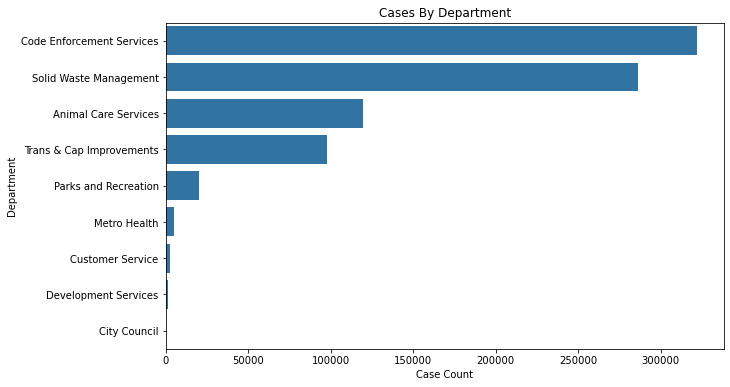

In [148]:
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="dept_name", data=case_dept, color="tab:blue")
plt.title('Cases By Department')
plt.xlabel('Case Count')
plt.ylabel('Department')
plt.show()

#### 2. Does the percentage of cases that are late vary by department?

In [64]:
(
    df.select(df.dept_division, df.case_late)
    .groupby(df.dept_division)
    .agg(F.sum(df.case_late=='YES'))
    .show(5)
)

AnalysisException: cannot resolve 'sum((case_late = 'YES'))' due to data type mismatch: function sum requires numeric or interval types, not boolean;
'Aggregate [dept_division#23], [dept_division#23, sum((case_late#20 = YES)) AS sum((case_late = YES))#698]
+- Project [dept_division#23, case_late#20]
   +- Project [source_id#27, dept_division#23, case_id#16, case_opened_date#17, case_closed_date#18, SLA_due_date#19, case_late#20, num_days_late#21, case_closed#22, service_request_type#24, SLA_days#25, case_status#26, request_address#28, council_district#29, dept_name#61, standardized_dept_name#62, dept_subject_to_SLA#63, source_username#85]
      +- Join LeftOuter, (source_id#27 = source_id#84)
         :- Project [dept_division#23, case_id#16, case_opened_date#17, case_closed_date#18, SLA_due_date#19, case_late#20, num_days_late#21, case_closed#22, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#29, dept_name#61, standardized_dept_name#62, dept_subject_to_SLA#63]
         :  +- Join LeftOuter, (dept_division#23 = dept_division#60)
         :     :- Relation [case_id#16,case_opened_date#17,case_closed_date#18,SLA_due_date#19,case_late#20,num_days_late#21,case_closed#22,dept_division#23,service_request_type#24,SLA_days#25,case_status#26,source_id#27,request_address#28,council_district#29] csv
         :     +- Relation [dept_division#60,dept_name#61,standardized_dept_name#62,dept_subject_to_SLA#63] csv
         +- Relation [source_id#84,source_username#85] csv


In [86]:
df.createOrReplaceTempView('df')

In [149]:
percent_late = spark.sql('''
SELECT dept_name, AVG(
    CASE 
        WHEN case_late = 'YES' Then 1
        ELSE 0 
    END) AS num_case_late
FROM df
GROUP BY dept_name
''').toPandas()

In [150]:
percent_late.head()

,dept_name,num_case_late
0,Animal Care Services,0.198983
1,Solid Waste Management,0.117815
2,Development Services,0.601288
3,Trans & Cap Improvements,0.056510
4,Customer Service,0.704396


In [151]:
#percent_late.num_case_late = round(percent_late.num_case_late * 100, 2)

In [152]:
percent_late = percent_late.sort_values(by='num_case_late', ascending=False, ignore_index=True)

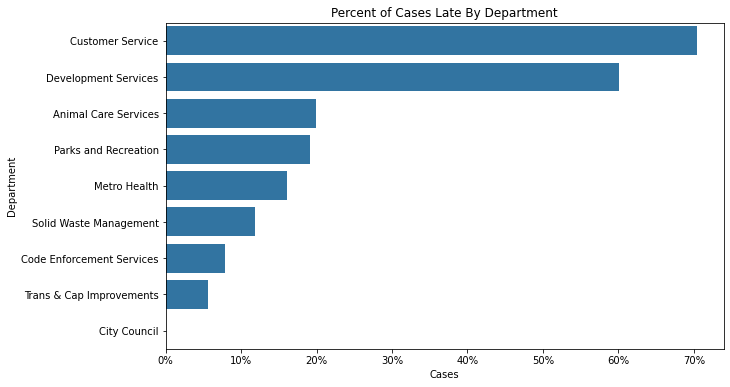

In [155]:
plt.figure(figsize=(10, 6))
sns.barplot(x="num_case_late", y="dept_name", data=percent_late, color="tab:blue")
plt.title('Percent of Cases Late By Department')
plt.xlabel('Cases')
plt.ylabel('Department')
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter("{:.0%}".format))
plt.show()

#### 3. On average, how late are the late cases by department?

#### 4. What is the service type that is the most late? Just for Parks & Rec?

#### 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

#### 6. Does whether or not its a weekend matter for when a case is opened/closed?

#### 7. On average, how many cases are opened a day for the Customer Service department?

#### 8. Does the number of service requests for the solid waste department vary by day of the week?